
<a href="https://colab.research.google.com/github/takzen/financial-ai-engineering-showcase/blob/main/notebooks/week_09_graphs/04_fraud_detection.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 🕵️‍♂️ Tydzień 9, Dzień 4: Fraud Detection & AML (Graph Algorithms)

Tradycyjne bazy danych (SQL) słabo radzą sobie ze śledzeniem przepływu pieniędzy przez wiele kont ("friend of a friend").
Grafy są do tego stworzone.

**Cele na dziś:**
1.  **Synthetic Data:** Generowanie sieci transakcji (z ukrytymi oszustami).
2.  **Cycle Detection:** Algorytmy szukania pętli (A -> B -> C -> A).
3.  **Visualisation:** Rysowanie grafu z podświetleniem oszustów na czerwono.

---
### 🛠️ 1. Instalacja

Wystarczy nam `networkx` i `matplotlib`.

In [ ]:
!uv add networkx matplotlib pandas numpy

### 💸 2. Generowanie Danych (Transakcje)

Stworzymy sieć składającą się z:
1.  **Uczciwych klientów:** Przelewają pieniądze losowo (np. pensja, zakupy).
2.  **Pralni pieniędzy (Fraud Ring):** Grupa kont, która przesyła pieniądze w kółko, żeby ukryć ich źródło.

In [1]:
import networkx as nx
import random
import matplotlib.pyplot as plt

def generate_transaction_network(num_nodes=20):
    G = nx.DiGraph() # Graf skierowany (Przelew ma kierunek)
    
    # 1. Dodajemy węzły (Konta)
    nodes = range(num_nodes)
    G.add_nodes_from(nodes)
    
    # 2. Dodajemy legalne transakcje (Losowe)
    # Każdy robi ok. 1-2 przelewy
    for u in nodes:
        # Losowy odbiorca (inny niż nadawca)
        potential_receivers = [v for v in nodes if v != u]
        if potential_receivers:
            v = random.choice(potential_receivers)
            amount = random.randint(100, 1000)
            G.add_edge(u, v, amount=amount, type="normal")
            
    return G

# Generujemy bazową sieć
random.seed(42) # Dla powtarzalności
G = generate_transaction_network(20)

print(f"✅ Sieć wygenerowana: {G.number_of_nodes()} kont, {G.number_of_edges()} przelewów.")

✅ Sieć wygenerowana: 20 kont, 20 przelewów.


### 🦠 3. Wstrzykiwanie Oszustwa (Fraud Ring)

Teraz ręcznie dodamy "Krąg Oszustów".
Konta: 100 -> 101 -> 102 -> 100.
Kwoty: Duże i równe (typowy znak prania brudnych pieniędzy - tzw. *layering*).

In [2]:
def inject_fraud_ring(G, nodes_in_ring):
    print(f"⚠️ Wstrzykiwanie oszustwa w węzłach: {nodes_in_ring}")
    
    # Tworzymy cykl A->B->C->A
    for i in range(len(nodes_in_ring)):
        u = nodes_in_ring[i]
        v = nodes_in_ring[(i + 1) % len(nodes_in_ring)] # Następny w kółku (modulo wraca na start)
        
        # Duża kwota, np. 9000-9900 (tuż pod progiem 10k)
        amount = 9500 
        
        # Dodajemy/Nadpisujemy krawędź
        G.add_edge(u, v, amount=amount, type="fraud")

# Dodajemy nowe węzły dla oszustów, żeby się nie mieszali z uczciwymi (dla jasności przykładu)
fraudsters = [100, 101, 102, 103]
G.add_nodes_from(fraudsters)

inject_fraud_ring(G, fraudsters)

print(f"Aktualny stan: {G.number_of_edges()} przelewów.")

⚠️ Wstrzykiwanie oszustwa w węzłach: [100, 101, 102, 103]
Aktualny stan: 24 przelewów.


### 🕵️‍♂️ 4. Algorytm Wykrywania (Cycle Detection)

W NetworkX mamy gotową funkcję `simple_cycles`. Znajduje ona wszystkie pętle w grafie skierowanym.
Nie każda pętla to oszustwo (mogę pożyczyć koledze 50 zł, a on mi odda – to też cykl A->B->A o długości 2).

Dlatego dodamy filtr: **Szukamy cykli o długości >= 3**.

In [3]:
def detect_money_laundering(G):
    print("🔍 Analiza grafu pod kątem cykli...")
    
    try:
        # Znajdź wszystkie cykle proste
        cycles = list(nx.simple_cycles(G))
    except ImportError:
        # Fallback dla starszych wersji networkx
        print("Błąd algorytmu. Upewnij się że masz networkx.")
        return []

    suspicious_cycles = []
    
    for cycle in cycles:
        # Filtr 1: Długość cyklu (Pralnie to zazwyczaj 3+ skoki)
        if len(cycle) >= 3:
            # Filtr 2: Sprawdzenie kwot (opcjonalne, tutaj uproszczone)
            # W prawdziwym AML sprawdzalibyśmy czy kwoty są podobne
            suspicious_cycles.append(cycle)
            
    return suspicious_cycles

found_cycles = detect_money_laundering(G)

print(f"\n🚨 Znaleziono {len(found_cycles)} podejrzanych cykli:")
for i, cycle in enumerate(found_cycles):
    print(f"   Cykl #{i+1}: {cycle}")

🔍 Analiza grafu pod kątem cykli...

🚨 Znaleziono 3 podejrzanych cykli:
   Cykl #1: [100, 101, 102, 103]
   Cykl #2: [8, 7, 2]
   Cykl #3: [0, 4, 18, 6, 1, 9]


### 🎨 5. Wizualizacja (Oznaczanie Celów)

Narysujmy graf.
*   **Niebieskie:** Uczciwe konta.
*   **Czerwone:** Wykryci oszuści.
*   **Czerwone strzałki:** Podejrzane transakcje.

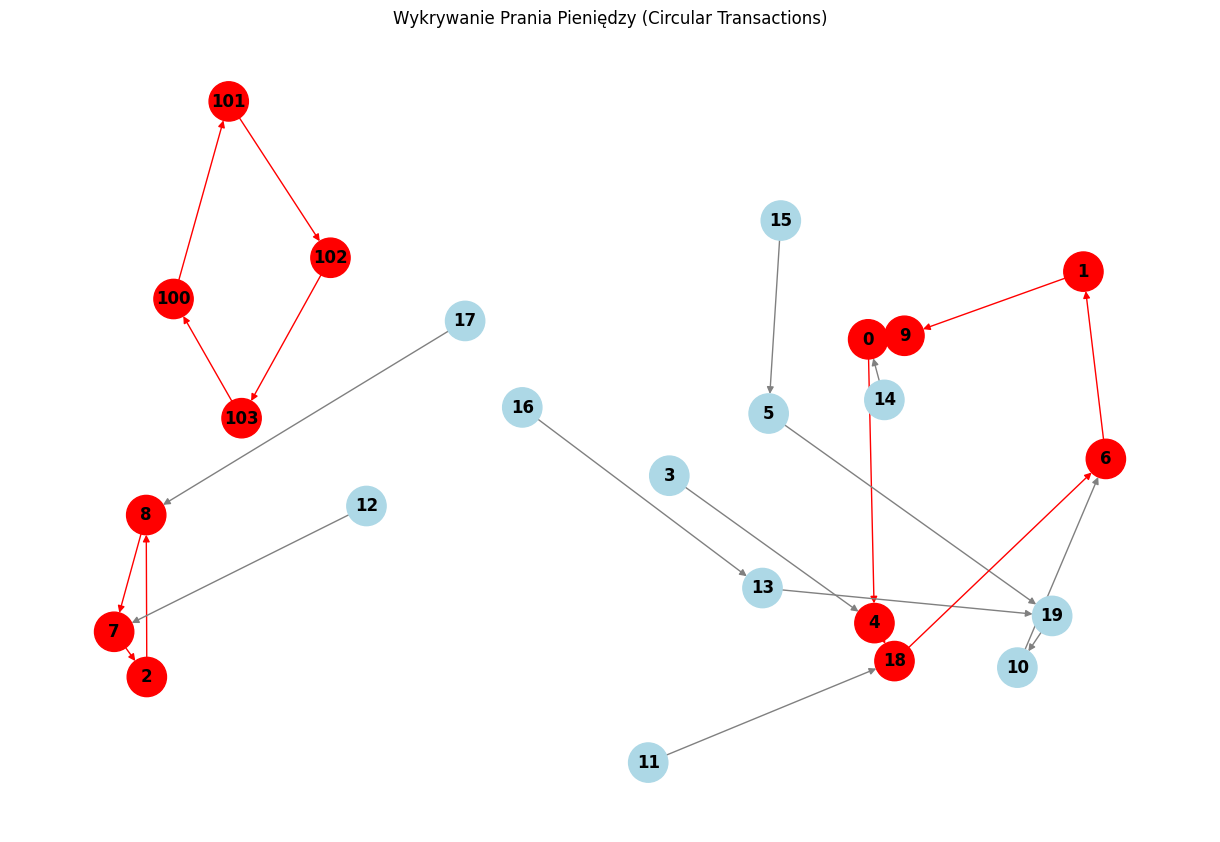

In [4]:
plt.figure(figsize=(12, 8))

pos = nx.spring_layout(G, k=0.6, seed=42)

# 1. Domyślny styl (wszyscy uczciwi)
node_colors = ['lightblue'] * len(G.nodes())
edge_colors = ['gray'] * len(G.edges())

# 2. Kolorowanie oszustów
# Spłaszczamy listę cykli do jednego zbioru węzłów
fraud_nodes = set()
for cycle in found_cycles:
    for node in cycle:
        fraud_nodes.add(node)

# Mapowanie kolorów węzłów
node_list = list(G.nodes())
for i, node in enumerate(node_list):
    if node in fraud_nodes:
        node_colors[i] = 'red'

# Mapowanie kolorów krawędzi (jeśli oba końce są w fraud_nodes)
edge_list = list(G.edges())
for i, (u, v) in enumerate(edge_list):
    if u in fraud_nodes and v in fraud_nodes:
        edge_colors[i] = 'red'

# Rysowanie
nx.draw(G, pos, 
        with_labels=True, 
        node_color=node_colors, 
        edge_color=edge_colors,
        node_size=800,
        font_weight='bold')

plt.title("Wykrywanie Prania Pieniędzy (Circular Transactions)")
plt.show()

## 🧠 Zadanie Domowe: Smurfing (Strukturyzacja)

Innym typem oszustwa jest **Smurfing** (Structuring).
Jeden węzeł ("Szef") rozsyła pieniądze do wielu "Słupów", a oni wypłacają gotówkę.
Wygląda to na grafie jak **Gwiazda** (jeden węzeł centralny wysyła do wielu).

**Zadanie:**
1. Napisz funkcję, która znajduje węzeł o nienaturalnie wysokim `out_degree` (liczba przelewów wychodzących).
2. Ustaw próg np. > 5 przelewów wychodzących.
3. Znajdź taki węzeł w wygenerowanym grafie (możesz dodać ręcznie "Szefa", który wysyła do 10 osób).
4. Wyświetl ID podejrzanego "Szefa".

🕵️‍♂️ Szukam schematu SMURFINGU (Struktury gwiazdy)...
✅ Dodano sztuczny schemat smurfingu (Szef: ACC_BOSS_SMURF).

🚨 Znaleziono 1 węzłów o wysokiej aktywności wychodzącej:
   🔴 ACC_BOSS_SMURF -> wykonał 8 przelewów


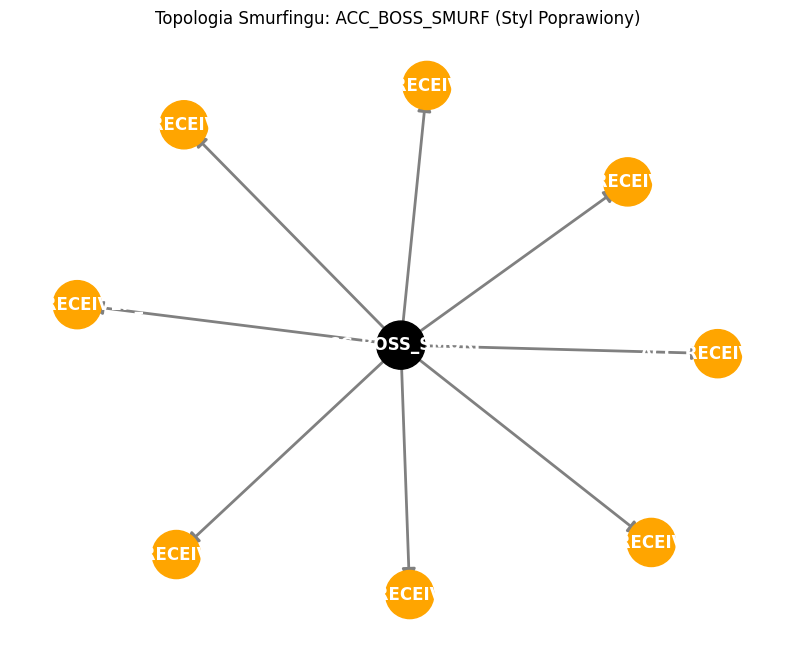

In [6]:
# --- ROZWIĄZANIE ZADANIA DOMOWEGO: Smurfing (Wizualizacja HD) ---

print("🕵️‍♂️ Szukam schematu SMURFINGU (Struktury gwiazdy)...")

# 1. Wstrzykujemy "Szefa"
boss_id = "ACC_BOSS_SMURF"
for i in range(8):
    target = f"ACC_RECEIVER_{i}"
    # Upewniamy się, że krawędź nie istnieje, żeby nie dublować
    if not G.has_edge(boss_id, target):
        G.add_edge(boss_id, target, amount=950, type="smurf_payment")

print(f"✅ Dodano sztuczny schemat smurfingu (Szef: {boss_id}).")

# 2. Funkcja Detekcji
def detect_smurfing(graph, threshold=5):
    suspects = []
    for node, degree in graph.out_degree():
        if degree > threshold:
            suspects.append((node, degree))
    return sorted(suspects, key=lambda x: x[1], reverse=True)

# 3. Uruchomienie analizy
high_out_degree_nodes = detect_smurfing(G, threshold=5)

print(f"\n🚨 Znaleziono {len(high_out_degree_nodes)} węzłów o wysokiej aktywności wychodzącej:")
for node, count in high_out_degree_nodes:
    print(f"   🔴 {node} -> wykonał {count} przelewów")

# 4. Wizualizacja (NAPRAWIONA)
if high_out_degree_nodes:
    top_suspect = high_out_degree_nodes[0][0]
    
    # Ego graph - sąsiedzi podejrzanego
    subgraph = nx.ego_graph(G, top_suspect, radius=1)
    
    plt.figure(figsize=(10, 8))
    
    # Layout - zwiększamy k, żeby rozsunąć węzły
    pos = nx.spring_layout(subgraph, seed=42, k=1.5)
    
    # Kolory
    node_colors = ['black' if n == top_suspect else 'orange' for n in subgraph.nodes()]
    
    # Rysujemy węzły
    nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=1200)
    
    # Rysujemy etykiety węzłów
    nx.draw_networkx_labels(subgraph, pos, font_color='white', font_weight='bold')
    
    # --- NAPRAWA LINII ---
    # Rysujemy krawędzie osobno, kontrolując styl strzałek
    nx.draw_networkx_edges(
        subgraph, 
        pos, 
        edge_color='gray', 
        arrows=True, 
        arrowsize=20, 
        arrowstyle='-|>',  # To sprawia, że strzałka jest ostra i nie "przerywa" linii
        width=2
    )
    
    plt.title(f"Topologia Smurfingu: {top_suspect} (Styl Poprawiony)")
    plt.axis("off") # Wyłącza osie XY
    plt.show()